LOADING OF DATASETS TO BE USED

In [23]:
import pandas as pd
import sqlite3

# File paths
file_paths = {
    'bom_movie_gross': 'C:/Users/adminepk.AD01/Documents/Phase 2 project/bom.movie_gross.csv.gz',
    'tmdb_movies': 'C:/Users/adminepk.AD01/Documents/Phase 2 project/tmdb.movies.csv.gz',
    'tn_movie_budgets': 'C:/Users/adminepk.AD01/Documents/Phase 2 project/tn.movie_budgets.csv.gz',
    'rt_reviews': r'C:\Users\adminepk.AD01\Documents\Phase 2 project\rt.reviews.tsv',
    'rt_movie_info': r'C:\Users\adminepk.AD01\Documents\Phase 2 project\rt.movie_info.tsv'
}

# Load the CSV and TSV datasets
datasets = {}
for name, path in file_paths.items():
    try:
        datasets[name] = pd.read_csv(path, compression='gzip' if path.endswith('.gz') else None, sep='\t' if path.endswith('.tsv') else ',', encoding='utf-8')
    except UnicodeDecodeError:
        datasets[name] = pd.read_csv(path, compression='gzip' if path.endswith('.gz') else None, sep='\t' if path.endswith('.tsv') else ',', encoding='latin1')

# Load the SQLite database
im_db_path = r'C:\Users\adminepk.AD01\Documents\Phase 2 project\im.db'
conn_im = sqlite3.connect(im_db_path)

# Assuming you want to load specific tables from the SQLite database
im_table_names = ['movie_basics', 'movie_ratings']
im_datasets = {table_name: pd.read_sql(f'SELECT * FROM {table_name}', conn_im) for table_name in im_table_names}

# Merge all datasets into one dictionary
all_datasets = {**datasets, **im_datasets}

# Display some columns from each dataset (if needed)
for name, df in all_datasets.items():
    print(f"{name} dataset:")
    print(df.head())

# Create a connection to the output SQLite database
output_db_path = 'movies.db'
conn_output = sqlite3.connect(output_db_path)

# Write the DataFrames to the output SQLite database
for name, df in all_datasets.items():
    df.to_sql(name, conn_output, if_exists='replace', index=False)

# Verify by reading back from the database
for name in all_datasets.keys():
    sample = pd.read_sql(f'SELECT * FROM {name} LIMIT 5', conn_output)
    print(f"{name} Sample:")
    print(sample)

# Close the connections
conn_im.close()
conn_output.close()

bom_movie_gross dataset:
                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010  
tmdb_movies dataset:
   Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   
2           2        [12, 28, 878]  10138                en   
3           3      [16, 35, 10751]    862                en   
4           4        [28, 878, 12]  27205               

MERGING OF THE DATASETS

In [24]:
# File paths
file_paths = {
    'rt_reviews': r'C:\Users\adminepk.AD01\Documents\Phase 2 project\rt.reviews.tsv',
    'rt_movie_info': r'C:\Users\adminepk.AD01\Documents\Phase 2 project\rt.movie_info.tsv',
    'tn_movie_budgets': 'C:/Users/adminepk.AD01/Documents/Phase 2 project/tn.movie_budgets.csv.gz'
}
# Load the datasets
datasets = {}
for name, path in file_paths.items():
    try:
        datasets[name] = pd.read_csv(path, compression='gzip' if path.endswith('.gz') else None, sep='\t' if path.endswith('.tsv') else ',', encoding='utf-8')
    except UnicodeDecodeError:
        datasets[name] = pd.read_csv(path, compression='gzip' if path.endswith('.gz') else None, sep='\t' if path.endswith('.tsv') else ',', encoding='latin1')

# Merge datasets on 'id'
merged_df = datasets['rt_reviews'].merge(datasets['rt_movie_info'], on='id', how='outer')
merged_df = merged_df.merge(datasets['tn_movie_budgets'], on='id', how='outer')
# Rename 'movie' to 'title'
merged_df.rename(columns={'movie': 'title'}, inplace=True)


# Display the first few rows of the combined dataset
print(merged_df.head())

# Save the merged dataset to a new SQLite database
output_db_path = 'combined_movies.db'
conn_output = sqlite3.connect(output_db_path)
merged_df.to_sql('combined_movies', conn_output, if_exists='replace', index=False)

# Verify by reading back from the database
sample = pd.read_sql('SELECT * FROM combined_movies LIMIT 5', conn_output)
print("Sample from combined dataset:")
print(sample)

# Close the connection to the output SQLite database
conn_output.close()

   id                                             review rating_x  fresh  \
0   3  A distinctly gallows take on contemporary fina...      3/5  fresh   
1   3  A distinctly gallows take on contemporary fina...      3/5  fresh   
2   3  A distinctly gallows take on contemporary fina...      3/5  fresh   
3   3  A distinctly gallows take on contemporary fina...      3/5  fresh   
4   3  A distinctly gallows take on contemporary fina...      3/5  fresh   

       critic  top_critic        publisher               date  \
0  PJ Nabarro         0.0  Patrick Nabarro  November 10, 2018   
1  PJ Nabarro         0.0  Patrick Nabarro  November 10, 2018   
2  PJ Nabarro         0.0  Patrick Nabarro  November 10, 2018   
3  PJ Nabarro         0.0  Patrick Nabarro  November 10, 2018   
4  PJ Nabarro         0.0  Patrick Nabarro  November 10, 2018   

                                            synopsis rating_y  ...  \
0  New York City, not-too-distant-future: Eric Pa...        R  ...   
1  New York 

In [25]:
# File paths for additional datasets
additional_file_paths = {
    'bom_movie_gross': 'C:/Users/adminepk.AD01/Documents/Phase 2 project/bom.movie_gross.csv.gz',
    'tmdb_movies': 'C:/Users/adminepk.AD01/Documents/Phase 2 project/tmdb.movies.csv.gz'
}
# Define the clean_title function to convert titles to lowercase
def clean_title(title):
    """Convert movie titles to lowercase."""
    return title.lower().strip()
# Load the additional datasets
for name, path in additional_file_paths.items():
    try:
        datasets[name] = pd.read_csv(path, compression='gzip' if path.endswith('.gz') else None, sep='\t' if path.endswith('.tsv') else ',', encoding='utf-8')
    except UnicodeDecodeError:
        datasets[name] = pd.read_csv(path, compression='gzip' if path.endswith('.gz') else None, sep='\t' if path.endswith('.tsv') else ',', encoding='latin1')

# Ensure consistent title cleaning in additional datasets
for name in ['bom_movie_gross', 'tmdb_movies']:
    datasets[name]['title'] = datasets[name]['title'].apply(clean_title)

# Merge on 'title'
final_merged_df = merged_df.merge(datasets['bom_movie_gross'], on='title', how='outer', suffixes=('', '_bom'))
final_merged_df = final_merged_df.merge(datasets['tmdb_movies'], on='title', how='outer', suffixes=('', '_tmdb'))



# Display the first few rows of the final combined dataset
print(final_merged_df.head())

# Save the final merged dataset to a new SQLite database
output_db_path = 'final_combined_movies.db'
conn_output = sqlite3.connect(output_db_path)
final_merged_df.to_sql('final_combined_movies', conn_output, if_exists='replace', index=False)

# Verify by reading back from the database
sample = pd.read_sql('SELECT * FROM final_combined_movies LIMIT 5', conn_output)
print("Sample from final combined dataset:")
print(sample)

# Close the connection to the output SQLite database
conn_output.close()

    id                                             review rating_x   fresh  \
0  3.0  A distinctly gallows take on contemporary fina...      3/5   fresh   
1  3.0  It's an allegory in search of a meaning that n...      NaN  rotten   
2  3.0  ... life lived in a bubble in financial dealin...      NaN   fresh   
3  3.0  Continuing along a line introduced in last yea...      NaN   fresh   
4  3.0             ... a perverse twist on neorealism...       NaN   fresh   

           critic  top_critic         publisher               date  \
0      PJ Nabarro         0.0   Patrick Nabarro  November 10, 2018   
1  Annalee Newitz         0.0           io9.com       May 23, 2018   
2    Sean Axmaker         0.0  Stream on Demand    January 4, 2018   
3   Daniel Kasman         0.0              MUBI  November 16, 2017   
4             NaN         0.0      Cinema Scope   October 12, 2017   

                                            synopsis rating_y  ... year  \
0  New York City, not-too-distant-f

CLEANING OF THE DATA

In [26]:
# Path to the final combined SQLite database
output_db_path = 'final_combined_movies.db'

# Connect to the SQLite database
conn_output = sqlite3.connect(output_db_path)

# Read the final merged dataset from the database
final_merged_df = pd.read_sql('SELECT * FROM final_combined_movies', conn_output)

# Close the connection to the SQLite database
conn_output.close()

# Count the number of missing values in each column
missing_values = final_merged_df.isnull().sum()

print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
id                     27518
review                 57805
rating_x               86480
fresh                  30289
critic                 41258
top_critic             30289
publisher              31279
date                   30289
synopsis               33811
rating_y               33608
genre                  33613
director               73906
writer                 91725
theater_date           40294
dvd_date               40294
currency              124246
box_office            124246
runtime                34490
studio                 95049
release_date           79156
title                  51638
production_budget      79156
domestic_gross         79156
worldwide_gross        79156
studio_bom            262765
domestic_gross_bom    262792
foreign_gross         264294
year                  262760
Unnamed: 0            239772
genre_ids             239772
id_tmdb               239772
original_language     239772
original_title        239772
po

In [27]:
# Path to the final combined SQLite database
output_db_path = 'final_combined_movies.db'

# Connect to the SQLite database
conn_output = sqlite3.connect(output_db_path)

# Read the final merged dataset from the database
final_merged_df = pd.read_sql('SELECT * FROM final_combined_movies', conn_output)

# Drop the 'rating_x' column if it exists
if 'rating_x' in final_merged_df.columns:
    final_merged_df.drop(columns=['rating_x'], inplace=True)

# Calculate the threshold for dropping rows (60% non-missing data)
row_threshold = final_merged_df.shape[1] * 0.6

# Drop rows with more than 40% missing data
final_merged_df = final_merged_df.dropna(thresh=row_threshold)

# Calculate the threshold for dropping columns (30% non-missing data)
column_threshold = final_merged_df.shape[0] * 0.3

# Drop columns with more than 70% missing data
final_merged_df = final_merged_df.dropna(axis=1, thresh=column_threshold)

# Count the number of missing values in each column
missing_values = final_merged_df.isnull().sum()

print("Number of missing values in each column after dropping rows with more than 40% missing data and columns with more than 70% missing data:")
print(missing_values)

# Save the updated DataFrame back to the SQLite database
final_merged_df.to_sql('final_combined_movies', conn_output, if_exists='replace', index=False)


# Close the connection to the SQLite database
conn_output.close()

Number of missing values in each column after dropping rows with more than 40% missing data and columns with more than 70% missing data:
id                       0
review                1575
fresh                    1
critic                1399
top_critic               1
publisher              347
date                     1
synopsis                 0
rating_y                 0
genre                    0
director               233
writer               10463
theater_date            22
dvd_date                22
currency                52
box_office              52
runtime                  0
studio                7418
release_date             0
title                    0
production_budget        0
domestic_gross           0
worldwide_gross          0
dtype: int64


In [28]:
# Path to the final combined SQLite database
output_db_path = 'final_combined_movies.db'

# Connect to the SQLite database
conn_output = sqlite3.connect(output_db_path)

# Read the final merged dataset from the database
final_merged_df = pd.read_sql('SELECT * FROM final_combined_movies', conn_output)

# Clean specific columns
# Replace missing values in specified columns
final_merged_df['review'].fillna('None', inplace=True)
final_merged_df['critic'].fillna('None', inplace=True)
final_merged_df['publisher'].fillna('Unknown', inplace=True)
final_merged_df['director'].fillna('Unknown', inplace=True)

# Drop rows with missing values in specified columns
columns_to_drop_rows = ['fresh', 'top_critic', 'date', 'theater_date']
final_merged_df.dropna(subset=columns_to_drop_rows, inplace=True)

# Drop rows with missing values in other specified columns
columns_to_drop_rows_with_na = ['dvd_date', 'currency', 'box_office']
final_merged_df.dropna(subset=columns_to_drop_rows_with_na, inplace=True)

# Drop specified columns
columns_to_drop = ['writer', 'studio']
final_merged_df.drop(columns=columns_to_drop, inplace=True)

# Check the number of missing values in each column after cleaning
missing_values = final_merged_df.isnull().sum()
print("Number of missing values in each column after cleaning:")
print(missing_values)

# Save the updated DataFrame back to the SQLite database
final_merged_df.to_sql('final_combined_movies', conn_output, if_exists='replace', index=False)

# Close the connection to the SQLite database
conn_output.close()

Number of missing values in each column after cleaning:
id                   0
review               0
fresh                0
critic               0
top_critic           0
publisher            0
date                 0
synopsis             0
rating_y             0
genre                0
director             0
theater_date         0
dvd_date             0
currency             0
box_office           0
runtime              0
release_date         0
title                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64


FINANCIAL PERFORMANCE RELATION TO RATING


Determine descriptive statistics

In [29]:
# Display descriptive statistics for financial performance and rating_y
print(final_merged_df[['rating_y', 'production_budget', 'domestic_gross', 'worldwide_gross']].describe())


       rating_y production_budget domestic_gross worldwide_gross
count     78403             78403          78403           78403
unique        3               192            675             703
top           R       $20,000,000             $0              $0
freq      45638              3295           8228            5328


In [30]:
# Get unique values in the 'rating_y' column
unique_ratings = final_merged_df['rating_y'].unique()

# Print the unique values
print("Unique values in 'rating_y':")
print(unique_ratings)


Unique values in 'rating_y':
['R' 'PG-13' 'PG']


Convert data into numeric form

In [31]:
# Convert financial columns to numeric
final_merged_df['production_budget'] = pd.to_numeric(final_merged_df['production_budget'].replace('[$,]', '', regex=True), errors='coerce')
final_merged_df['domestic_gross'] = pd.to_numeric(final_merged_df['domestic_gross'].replace('[$,]', '', regex=True), errors='coerce')
final_merged_df['worldwide_gross'] = pd.to_numeric(final_merged_df['worldwide_gross'].replace('[$,]', '', regex=True), errors='coerce')

# Encode 'rating_y' 
rating_mapping = {'PG': 1, 'PG-13': 2, 'R': 3}
final_merged_df['rating_y_encoded'] = final_merged_df['rating_y'].map(rating_mapping)



Correlation calculation and visualization

In [32]:
# Calculate correlation matrix for all relevant columns
correlation_matrix = final_merged_df[['rating_y_encoded', 'production_budget', 'domestic_gross', 'worldwide_gross']].corr()

# Display the correlation matrix
print(correlation_matrix)

                   rating_y_encoded  production_budget  domestic_gross  \
rating_y_encoded           1.000000           0.016087       -0.029166   
production_budget          0.016087           1.000000        0.538791   
domestic_gross            -0.029166           0.538791        1.000000   
worldwide_gross           -0.004877           0.645692        0.927881   

                   worldwide_gross  
rating_y_encoded         -0.004877  
production_budget         0.645692  
domestic_gross            0.927881  
worldwide_gross           1.000000  


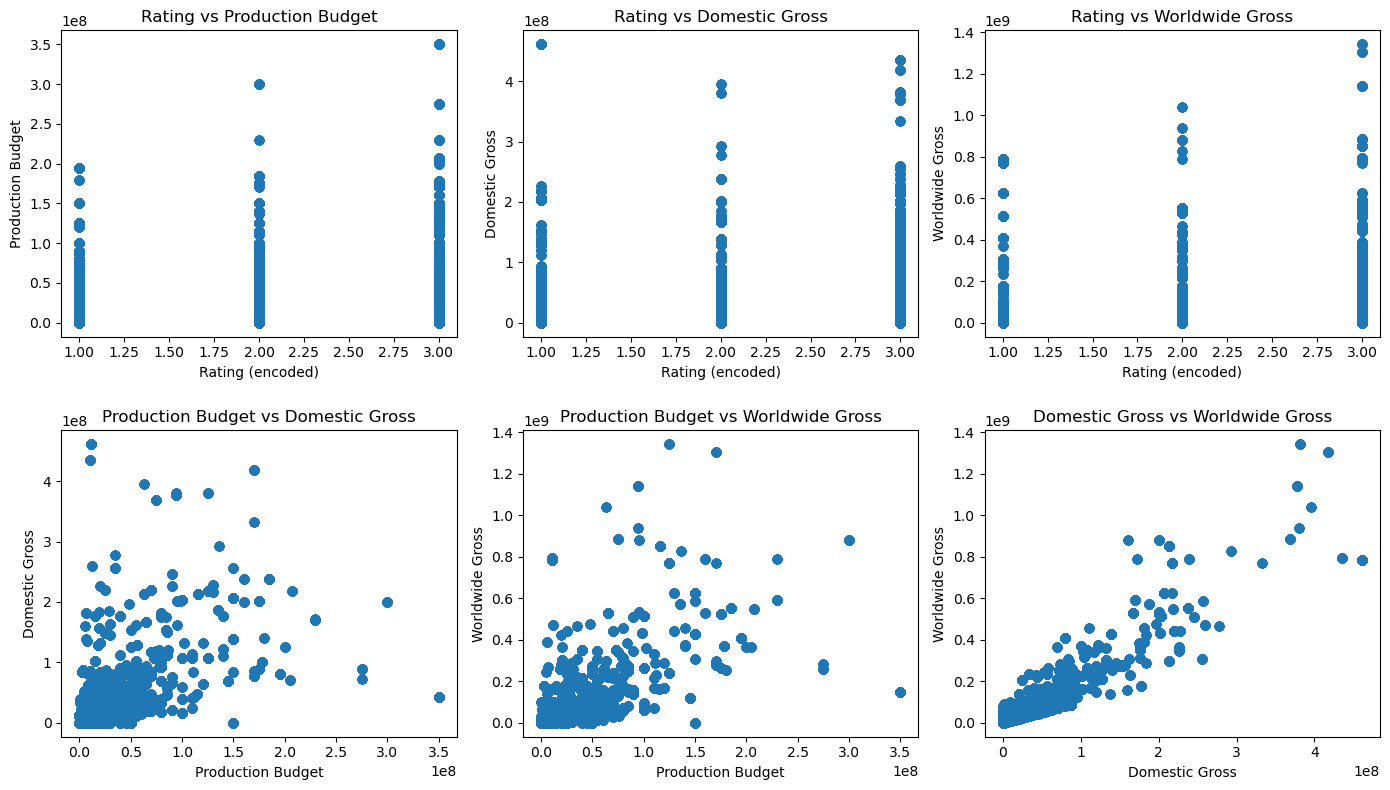

In [33]:
import matplotlib.pyplot as plt

# Scatter plot for rating vs production budget
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.scatter(final_merged_df['rating_y_encoded'], final_merged_df['production_budget'], alpha=0.5)
plt.title('Rating vs Production Budget')
plt.xlabel('Rating (encoded)')
plt.ylabel('Production Budget')

# Scatter plot for rating vs domestic gross
plt.subplot(2, 3, 2)
plt.scatter(final_merged_df['rating_y_encoded'], final_merged_df['domestic_gross'], alpha=0.5)
plt.title('Rating vs Domestic Gross')
plt.xlabel('Rating (encoded)')
plt.ylabel('Domestic Gross')

# Scatter plot for rating vs worldwide gross
plt.subplot(2, 3, 3)
plt.scatter(final_merged_df['rating_y_encoded'], final_merged_df['worldwide_gross'], alpha=0.5)
plt.title('Rating vs Worldwide Gross')
plt.xlabel('Rating (encoded)')
plt.ylabel('Worldwide Gross')

# Scatter plot for production budget vs domestic gross
plt.subplot(2, 3, 4)
plt.scatter(final_merged_df['production_budget'], final_merged_df['domestic_gross'], alpha=0.5)
plt.title('Production Budget vs Domestic Gross')
plt.xlabel('Production Budget')
plt.ylabel('Domestic Gross')

# Scatter plot for production budget vs worldwide gross
plt.subplot(2, 3, 5)
plt.scatter(final_merged_df['production_budget'], final_merged_df['worldwide_gross'], alpha=0.5)
plt.title('Production Budget vs Worldwide Gross')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')

# Scatter plot for domestic gross vs worldwide gross
plt.subplot(2, 3, 6)
plt.scatter(final_merged_df['domestic_gross'], final_merged_df['worldwide_gross'], alpha=0.5)
plt.title('Domestic Gross vs Worldwide Gross')
plt.xlabel('Domestic Gross')
plt.ylabel('Worldwide Gross')

plt.tight_layout()
plt.show()


LINEAR REGRESSION

In [34]:
import statsmodels.api as sm

# Prepare features and target variables
X = final_merged_df[['rating_y_encoded', 'production_budget']]
X = sm.add_constant(X)  # Add intercept

# Domestic gross model
y_domestic = final_merged_df['domestic_gross']
model_domestic = sm.OLS(y_domestic, X).fit()
print("Domestic Gross Model Summary:")
print(model_domestic.summary())

# Worldwide gross model
y_worldwide = final_merged_df['worldwide_gross']
model_worldwide = sm.OLS(y_worldwide, X).fit()
print("Worldwide Gross Model Summary:")
print(model_worldwide.summary())



Domestic Gross Model Summary:
                            OLS Regression Results                            
Dep. Variable:         domestic_gross   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                 1.615e+04
Date:                Fri, 26 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:59:54   Log-Likelihood:            -1.5070e+06
No. Observations:               78403   AIC:                         3.014e+06
Df Residuals:                   78400   BIC:                         3.014e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

Production Budget vs Domestic gross

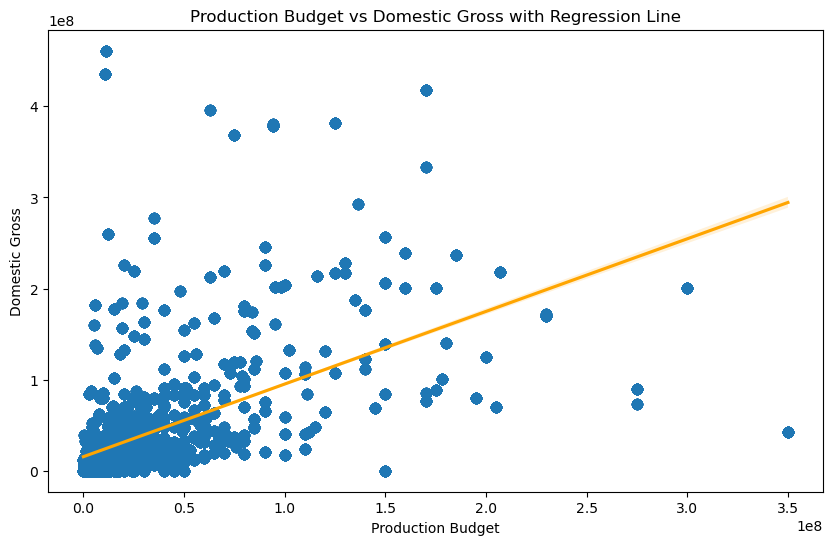

In [35]:
import seaborn as sns
# Scatter plot and regression line for Production Budget vs Domestic Gross
plt.figure(figsize=(10, 6))
sns.regplot(x='production_budget', y='domestic_gross', data=final_merged_df, scatter_kws={'s':50}, line_kws={'color':'orange'})
plt.title('Production Budget vs Domestic Gross with Regression Line')
plt.xlabel('Production Budget')
plt.ylabel('Domestic Gross')
plt.show()


Production Budget vs. Worldwide Gross

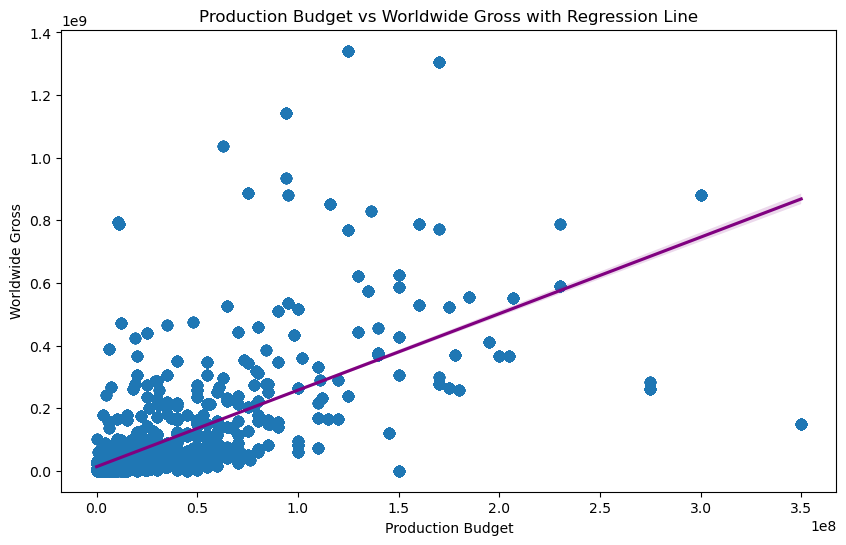

In [36]:
# Scatter plot and regression line for Production Budget vs Worldwide Gross
plt.figure(figsize=(10, 6))
sns.regplot(x='production_budget', y='worldwide_gross', data=final_merged_df, scatter_kws={'s':50}, line_kws={'color':'purple'})
plt.title('Production Budget vs Worldwide Gross with Regression Line')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.show()

Visualize Predictions

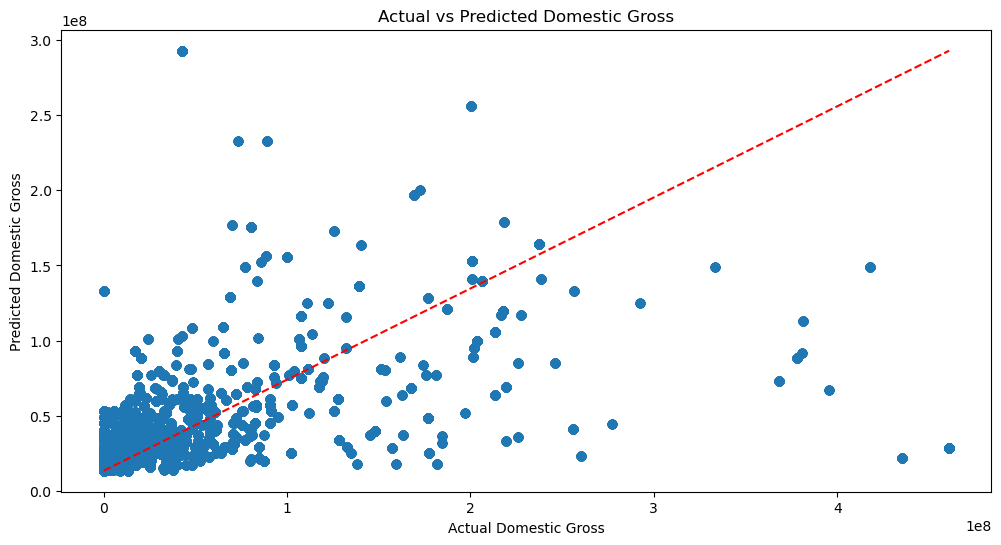

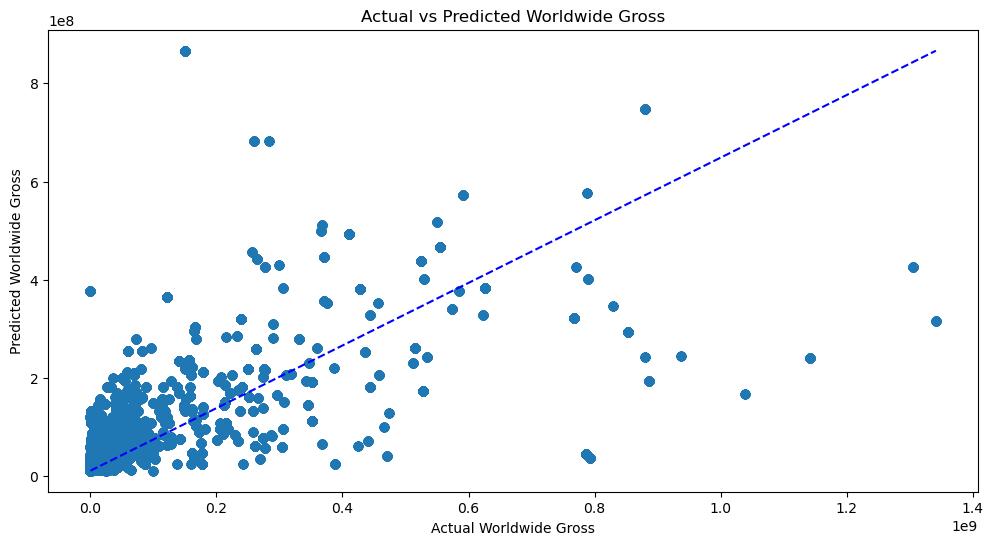

In [37]:
# Predict domestic and worldwide gross using the fitted models
final_merged_df['predicted_domestic'] = model_domestic.predict(X)
final_merged_df['predicted_worldwide'] = model_worldwide.predict(X)

# Plot Actual vs Predicted for Domestic Gross
plt.figure(figsize=(12, 6))
plt.scatter(final_merged_df['domestic_gross'], final_merged_df['predicted_domestic'], alpha=0.5)
plt.plot([final_merged_df['domestic_gross'].min(), final_merged_df['domestic_gross'].max()],
         [final_merged_df['predicted_domestic'].min(), final_merged_df['predicted_domestic'].max()],
         color='red', linestyle='--')
plt.title('Actual vs Predicted Domestic Gross')
plt.xlabel('Actual Domestic Gross')
plt.ylabel('Predicted Domestic Gross')
plt.show()

# Plot Actual vs Predicted for Worldwide Gross
plt.figure(figsize=(12, 6))
plt.scatter(final_merged_df['worldwide_gross'], final_merged_df['predicted_worldwide'], alpha=0.5)
plt.plot([final_merged_df['worldwide_gross'].min(), final_merged_df['worldwide_gross'].max()],
         [final_merged_df['predicted_worldwide'].min(), final_merged_df['predicted_worldwide'].max()],
         color='blue', linestyle='--')
plt.title('Actual vs Predicted Worldwide Gross')
plt.xlabel('Actual Worldwide Gross')
plt.ylabel('Predicted Worldwide Gross')
plt.show()


DIRECTORS AND MOVIE SUCCESS

           director  number_of_movies
0         Tom Hanks             10556
1        Kevin Lima             10208
2  David Cronenberg              9454
3       Ben Younger              7125
4      Jim Jarmusch              6612


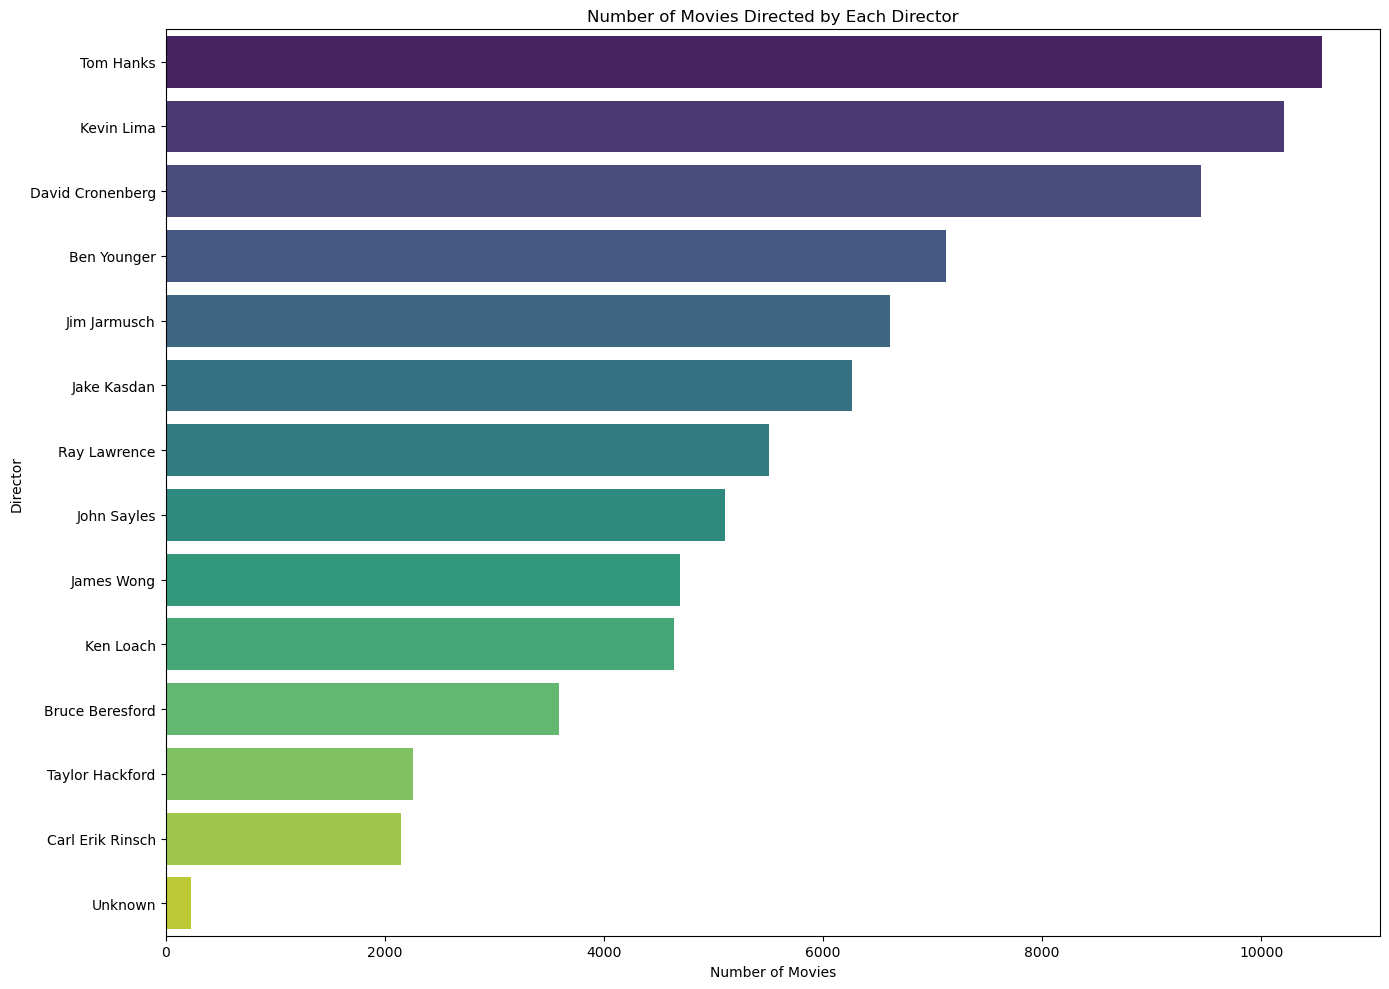

In [38]:
# Grouping by director and counting the number of movies
director_movie_count = final_merged_df['director'].value_counts().reset_index()
director_movie_count.columns = ['director', 'number_of_movies']

# Display the first few rows
print(director_movie_count.head())

# Plotting the number of movies directed by each director
plt.figure(figsize=(14, 10))
sns.barplot(x='number_of_movies', y='director', data=director_movie_count, palette='viridis')
plt.title('Number of Movies Directed by Each Director')
plt.xlabel('Number of Movies')
plt.ylabel('Director')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Average money spent by directors and the gross income from the movies

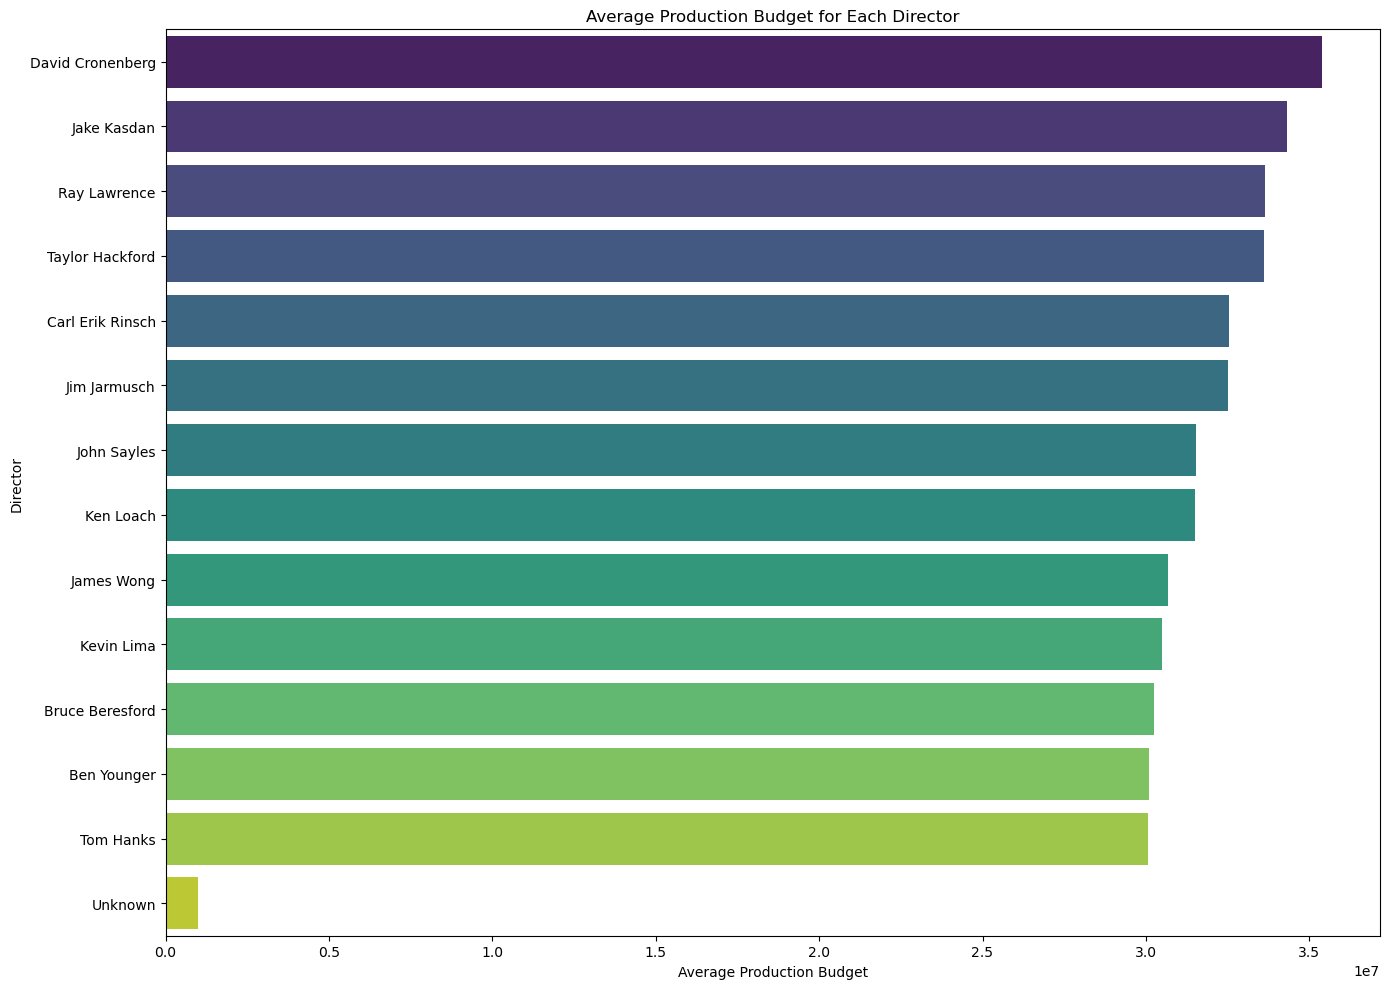

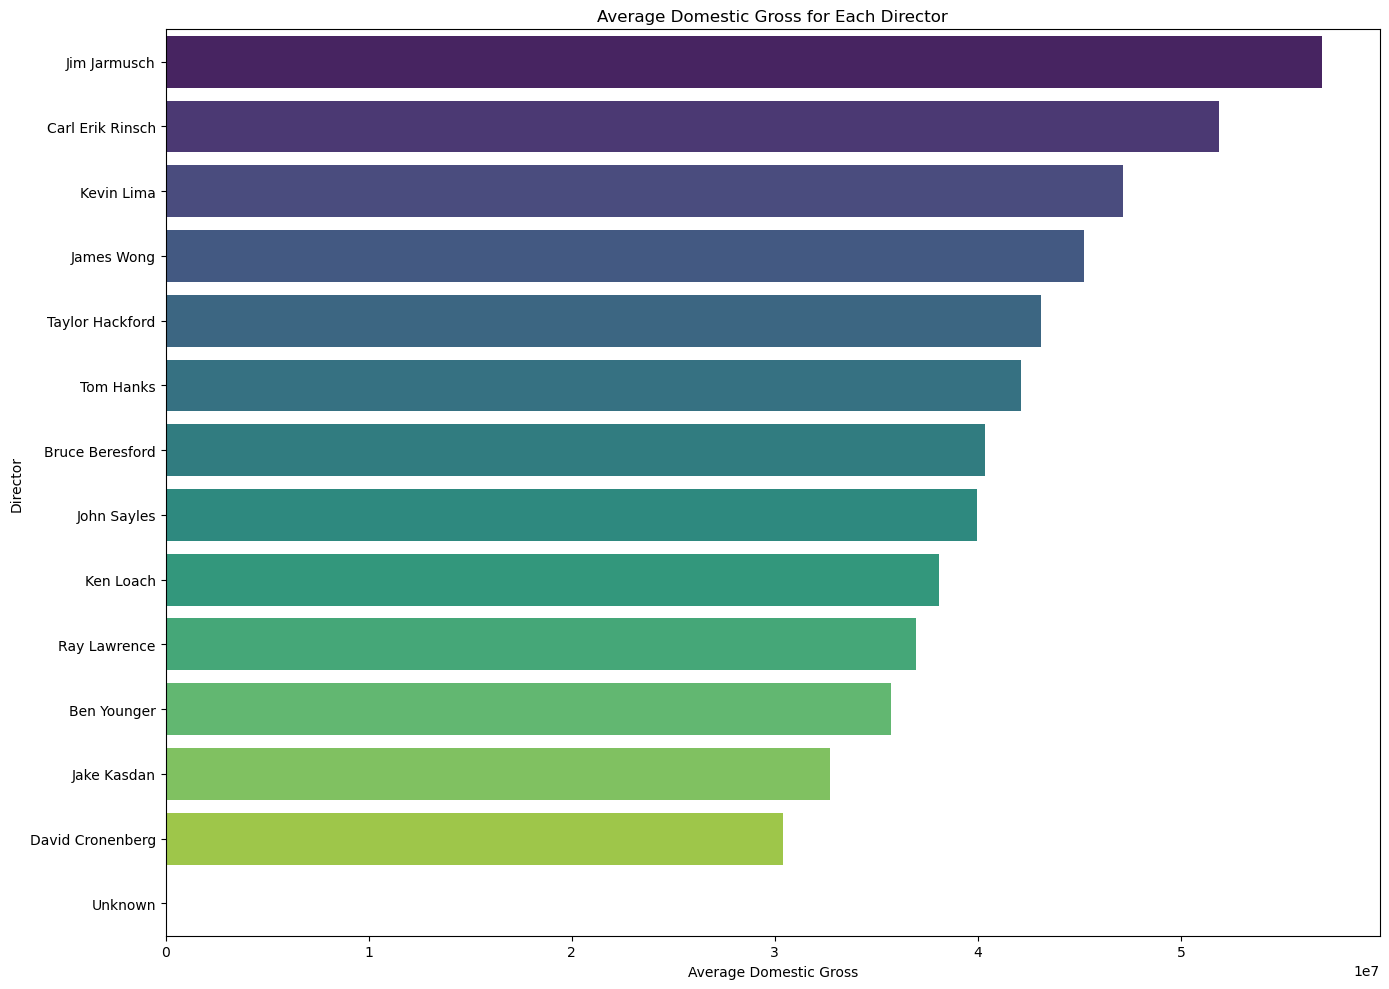

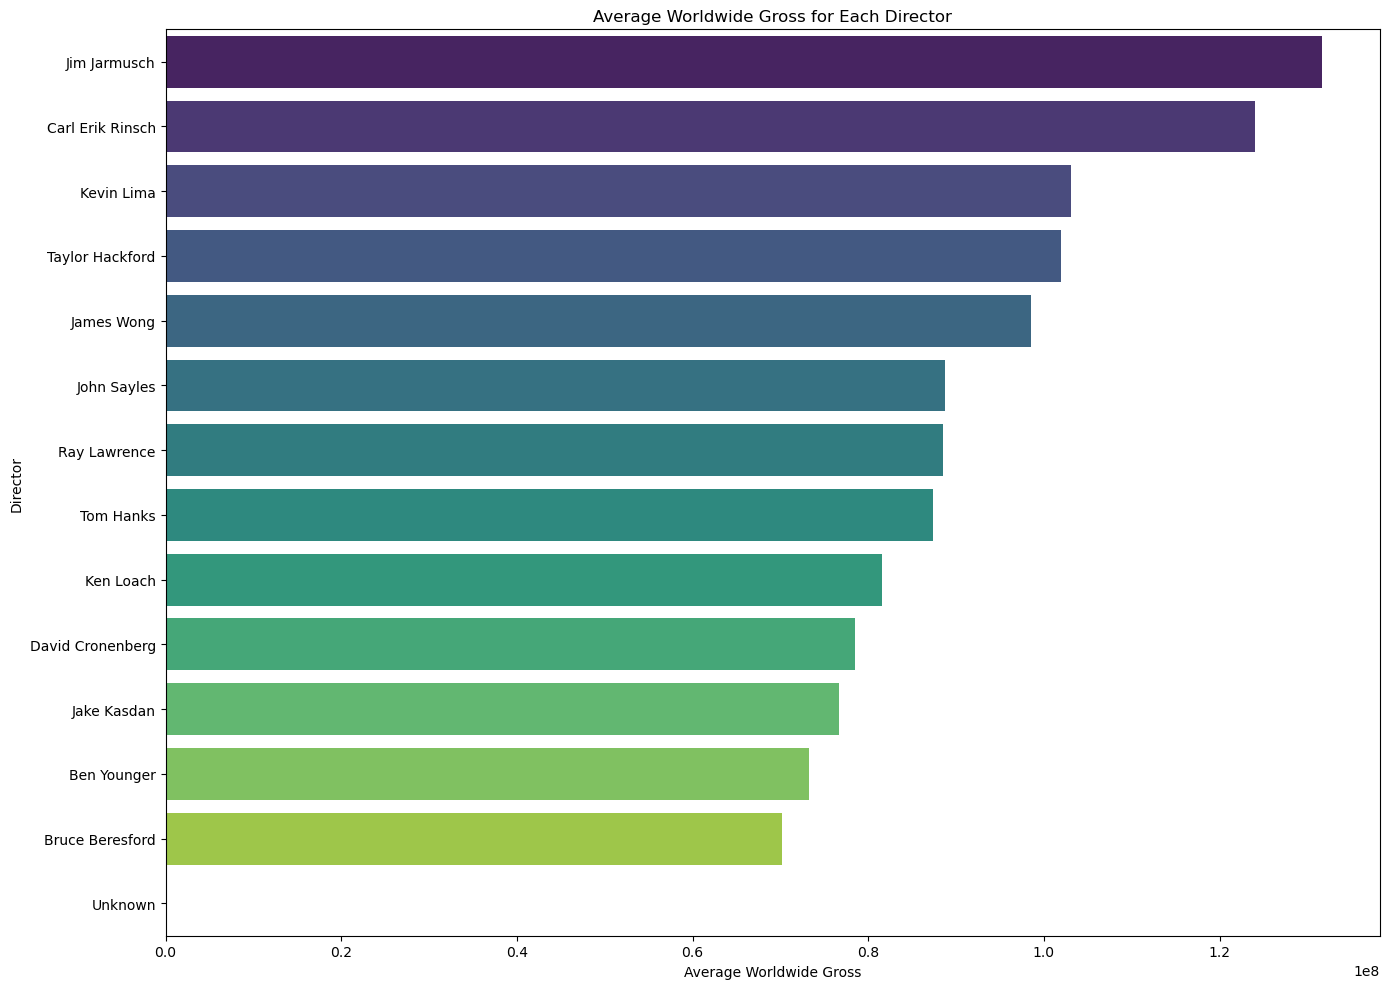

In [40]:
# Grouping by director and calculating the average values
director_avg = final_merged_df.groupby('director')[['production_budget', 'domestic_gross', 'worldwide_gross']].mean().reset_index()

# Sort by average production budget in descending order
director_avg_budget_sorted = director_avg.sort_values(by='production_budget', ascending=False)

# Plotting the average production budget for each director
plt.figure(figsize=(14, 10))
sns.barplot(x='production_budget', y='director', data=director_avg_budget_sorted, palette='viridis')
plt.title('Average Production Budget for Each Director')
plt.xlabel('Average Production Budget')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

# Sort by average domestic gross in descending order
director_avg_domestic_sorted = director_avg.sort_values(by='domestic_gross', ascending=False)

# Plotting the average domestic gross for each director
plt.figure(figsize=(14, 10))
sns.barplot(x='domestic_gross', y='director', data=director_avg_domestic_sorted, palette='viridis')
plt.title('Average Domestic Gross for Each Director')
plt.xlabel('Average Domestic Gross')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

# Sort by average worldwide gross in descending order
director_avg_worldwide_sorted = director_avg.sort_values(by='worldwide_gross', ascending=False)

# Plotting the average worldwide gross for each director
plt.figure(figsize=(14, 10))
sns.barplot(x='worldwide_gross', y='director', data=director_avg_worldwide_sorted, palette='viridis')
plt.title('Average Worldwide Gross for Each Director')
plt.xlabel('Average Worldwide Gross')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

A/B Testing 
Hypothesis:Movies directed by Tom Hanks generate significantly higher gross earnings compared to movies directed by other directors.

T-statistic: 2.7942021478752155, P-value: 0.005208698758712483


c:\Users\adminepk.AD01\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adminepk.AD01\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


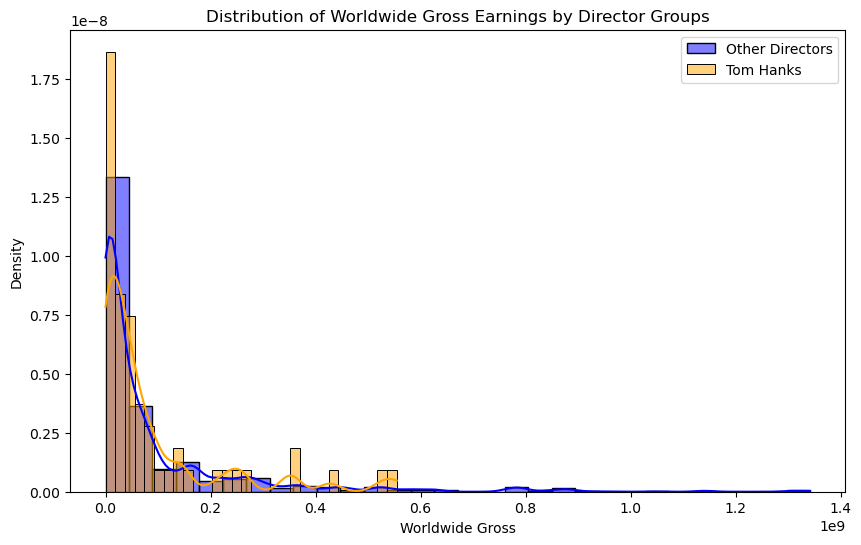

In [42]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
#  high-profile director
high_profile_director = 'Tom Hanks'

# Create the control and test groups
group_A = final_merged_df[final_merged_df['director'] != high_profile_director]['worldwide_gross'].dropna()
group_B = final_merged_df[final_merged_df['director'] == high_profile_director]['worldwide_gross'].dropna()

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(group_A, group_B, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(group_A, color='blue', label='Other Directors', kde=True, stat='density', bins=30)
sns.histplot(group_B, color='orange', label=high_profile_director, kde=True, stat='density', bins=30)
plt.title('Distribution of Worldwide Gross Earnings by Director Groups')
plt.xlabel('Worldwide Gross')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: 2.7942021478752155, P-value: 0.005208698758712483


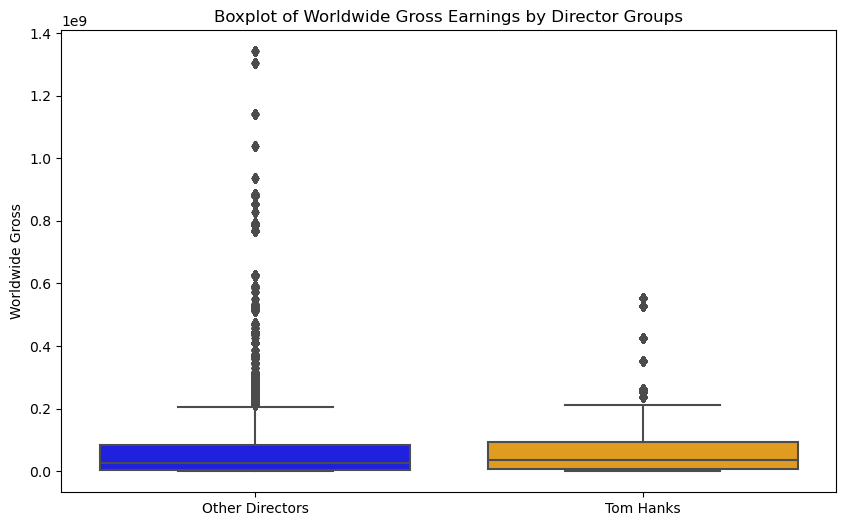

In [43]:
# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(group_A, group_B, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

# Plotting the results with boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=[group_A, group_B], palette=['blue', 'orange'])
plt.xticks([0, 1], ['Other Directors', 'Tom Hanks'])
plt.title('Boxplot of Worldwide Gross Earnings by Director Groups')
plt.ylabel('Worldwide Gross')
plt.show()
